# Multilabel classification for multiple behavioural attributes

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [60]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                ## value of resampling
session_now = 1
BINS = 70
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [61]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_unsup = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_unsupervised/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
behaviour_dir_parameters = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram_parameters/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/center_of_mass/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [62]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
behaviour_list_unsup = []
parameters_list = []
tracking_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_parameters.npy'
    ## LOAD PARAMETRS FOR BEHAVIOUR CLASSIFICATION
    parameters = np.load(behaviour_dir_parameters + beh_file_name_1)
    params = []
    for param in range(parameters.shape[0]):
        r1_params = np.reshape(parameters[param,:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
        r2_params = np.reshape(scipy.stats.mode(r1_params,axis=1)[0],reshape_behaviour.shape[0])
        params.append(r2_params)
    resample_params = np.array(params)
    
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                        re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    parameters_list.append(resample_params)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = neural_activity1
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1
    

In [63]:
## define targets of behaviour according to protocol (random, overlapping and stable)

id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour_list)):
        for trial in range(5):
            behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour_list)):
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
        behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
        behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour_list)):
        objects = np.unique(behaviour_list[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4      
    
        index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
        behaviour_list[day][index0] = 5
        behaviour_list[day][index1] = 6
        behaviour_list[day][index2] = 6  

In [64]:
def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    
    return index

def binned_tracking(tracking = None, binnumber = 70):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    
    
    xdenom = int(np.max(xpos)/binnumber+1)
    ydenom = int(np.max(ypos)/binnumber+1)
    
    xnew = [int(xpos[i]/xdenom) for i in range(tracking.shape[1])]
    ynew = [int(ypos[i]/xdenom) for i in range(tracking.shape[1])]
    
    return xnew,ynew

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

day = 0
CMBINS = 2
SPEED_THRES = 3
DISTANCE = 200
ANGLE = math.pi / 2
FR_limit = 12
#index = speed_selection(tracking_list[day], speed_limit = 3)
print(parameters_list[day].shape)
### center of mass parameters
cm = parameters_list[day][0:2,:].T
ypre = np.array(binned_tracking(tracking = cm.T, binnumber = BINS )).T
index = np.logical_and(ypre[:,0]>=0,ypre[:,1]>=0)
cmbinsx = ypre[index,0]
cmbinsy = ypre[index,1]

### object distance parameters
d1 = parameters_list[day][4,:]
d1 = d1[index]
print(index.shape)
d1bins = np.zeros_like(d1)
d1bins[np.where(d1<DISTANCE)[0]] = 1

d2 = parameters_list[day][5,:]
d2 = d2[index]
d2bins = np.zeros_like(d1)
d2bins[np.where(d2<DISTANCE)[0]] = 1

### speed parameters
speed = parameters_list[day][6,:]
speed = speed[index]
speedbins = np.zeros_like(speed)
speedbins[np.where(speed>SPEED_THRES)[0]] = 1

## angle
angle1 = parameters_list[day][11,:]
angle1 = angle1[index]
a1bins = np.zeros_like(angle1)
a1bins[np.where(angle1 > ANGLE)[0]] = 1

angle2 = parameters_list[day][12,:]
angle2 = angle2[index]
a2bins = np.zeros_like(angle2)
a2bins[np.where(angle2 > ANGLE)[0]] = 1

ybinarized = np.array([cmbinsx, cmbinsy,d1bins, d2bins,speedbins,a1bins,a2bins]).T


(13, 3236)
(3236,)


In [66]:
Xpre = activity_list[day].T
Xpre = Xpre[index,:]
firing_rate = np.mean(Xpre,axis = 0)*10
selected_cells = np.where(firing_rate < FR_limit)[0]
X = Xpre[:,selected_cells]
#X = X.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, ybinarized, test_size=0.1, random_state=0)

from sklearn.cross_decomposition import CCA
from sklearn.neighbors import KNeighborsClassifier

cca = CCA(n_components=7)
model = cca.fit(X_train, y_train)
X_embedded = model.transform(X)



In [67]:
from sklearn.manifold import TSNE
n_components = 2
embedding = TSNE(n_components=n_components).fit_transform(X_embedded)

(3186, 7)


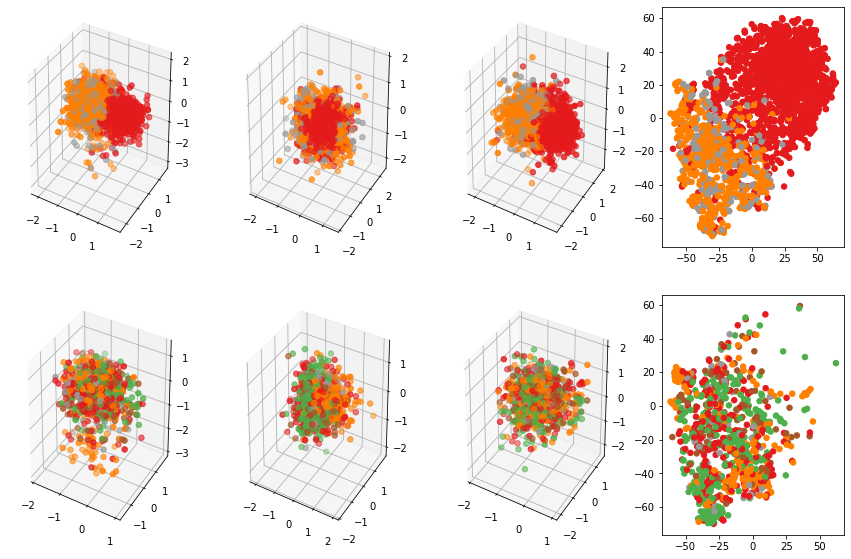

In [68]:
#print(acc_knn)
print(X_embedded.shape)
ybehaviour = behaviour_list[day][index]

# Plot the projected points and show the evaluation score
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(3, 4)


ax1 = fig.add_subplot(grid[0,0],projection='3d')
#ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=ybehaviour, s=30, cmap='Set1')
#selection = np.where(ybehaviour>2)[0]
selection = np.logical_and(ybehaviour>=0,ybehaviour<=2)
ax1.scatter(X_embedded[selection, 0], X_embedded[selection, 1], X_embedded[selection, 2], c=ybehaviour[selection], s=30, cmap='Set1')

ax2 = fig.add_subplot(grid[0,1],projection='3d')
ax2.scatter(X_embedded[selection, 3], X_embedded[selection, 4], X_embedded[selection, 5], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[0,2],projection='3d')
ax3.scatter(X_embedded[selection, 0], X_embedded[selection, 5], X_embedded[selection, 6], c=ybehaviour[selection], s=30, cmap='Set1')

ax4 = fig.add_subplot(grid[0,3])
ax4.scatter(embedding[selection, 0], embedding[selection, 1], c=ybehaviour[selection], s=30, cmap='Set1')

ax1 = fig.add_subplot(grid[1,0],projection='3d')
#ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=ybehaviour, s=30, cmap='Set1')
#selection = np.where(ybehaviour>2)[0]
selection = np.logical_and(ybehaviour>=2,ybehaviour<=7)
ax1.scatter(X_embedded[selection, 0], X_embedded[selection, 1], X_embedded[selection, 2], c=ybehaviour[selection], s=30, cmap='Set1')

ax2 = fig.add_subplot(grid[1,1],projection='3d')
ax2.scatter(X_embedded[selection, 3], X_embedded[selection, 4], X_embedded[selection, 5], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[1,2],projection='3d')
ax3.scatter(X_embedded[selection, 0], X_embedded[selection, 5], X_embedded[selection, 6], c=ybehaviour[selection], s=30, cmap='Set1')

ax4 = fig.add_subplot(grid[1,3])
ax4.scatter(embedding[selection, 0], embedding[selection, 1], c=ybehaviour[selection], s=30, cmap='Set1')



In [69]:
knn = KNeighborsClassifier(n_neighbors=3)

model = cca.fit(X_train, y_train)
# Fit a nearest neighbor classifier on the embedded training set
knn.fit(model.transform(X_train), y_train)

# Compute the nearest neighbor accuracy on the embedded test set
#acc_knn = knn.score(model.transform(X_test), y_test)

# Embed the data set in 2 dimensions using the fitted model
X_embedded = knn.predict(model.transform(X))

In [70]:
from sklearn.manifold import TSNE
n_components = 2
embedding = TSNE(n_components=n_components).fit_transform(X_embedded)
#from sklearn.manifold import MDS
#embedding = MDS(n_components=2).fit_transform(X_embedded)

In [71]:
#from sklearn.manifold import TSNE
#n_components = 2
#embedding = TSNE(n_components=n_components).fit_transform(X_embedded)
#from sklearn.manifold import MDS
#embedding = MDS(n_components=2).fit_transform(X_embedded)

(3186, 7)


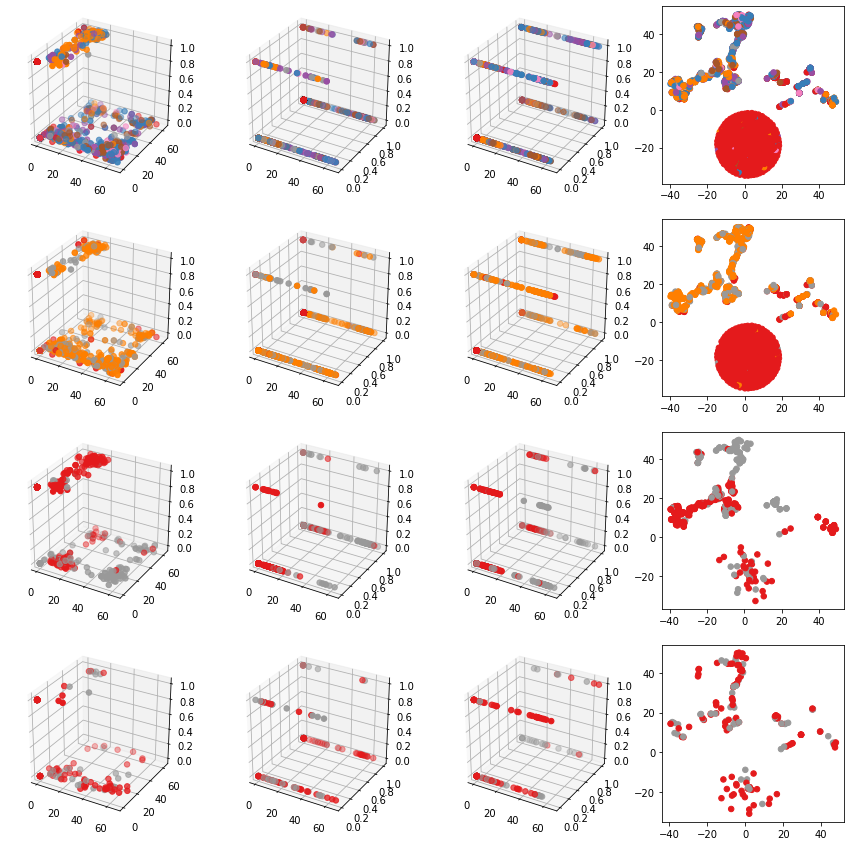

In [79]:
#print(acc_knn)
print(X_embedded.shape)
ybehaviour = behaviour_list[day][index]

# Plot the projected points and show the evaluation score
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(4, 4)

ax1 = fig.add_subplot(grid[0,0],projection='3d')
#ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=ybehaviour, s=30, cmap='Set1')
#selection = np.where(ybehaviour>2)[0]
selection = np.logical_and(ybehaviour>=0,ybehaviour>=0)
ax1.scatter(X_embedded[selection, 0], X_embedded[selection, 1], X_embedded[selection, 2], c=ybehaviour[selection], s=30, cmap='Set1')

ax2 = fig.add_subplot(grid[0,1],projection='3d')
ax2.scatter(X_embedded[selection, 0], X_embedded[selection, 3], X_embedded[selection, 4], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[0,2],projection='3d')
ax3.scatter(X_embedded[selection, 0], X_embedded[selection, 5], X_embedded[selection, 6], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[0,3])
ax3.scatter(embedding[selection, 0], embedding[selection, 1], c=ybehaviour[selection], s=30, cmap='Set1')


ax1 = fig.add_subplot(grid[1,0],projection='3d')
#ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=ybehaviour, s=30, cmap='Set1')
#selection = np.where(ybehaviour>2)[0]
selection = np.logical_and(ybehaviour<=2,ybehaviour>=0)
ax1.scatter(X_embedded[selection, 0], X_embedded[selection, 1], X_embedded[selection, 2], c=ybehaviour[selection], s=30, cmap='Set1')

ax2 = fig.add_subplot(grid[1,1],projection='3d')
ax2.scatter(X_embedded[selection, 0], X_embedded[selection, 3], X_embedded[selection, 4], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[1,2],projection='3d')
ax3.scatter(X_embedded[selection, 0], X_embedded[selection, 5], X_embedded[selection, 6], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[1,3])
ax3.scatter(embedding[selection, 0], embedding[selection, 1], c=ybehaviour[selection], s=30, cmap='Set1')


ax1 = fig.add_subplot(grid[2,0],projection='3d')
#ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=ybehaviour, s=30, cmap='Set1')
selection = np.logical_and(ybehaviour>2,ybehaviour<5)
#selection = np.logical_and(ybehaviour<2,ybehaviour>=0)
ax1.scatter(X_embedded[selection, 0], X_embedded[selection, 1], X_embedded[selection, 2], c=ybehaviour[selection], s=30, cmap='Set1')

ax2 = fig.add_subplot(grid[2,1],projection='3d')
ax2.scatter(X_embedded[selection, 0], X_embedded[selection, 3], X_embedded[selection, 4], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[2,2],projection='3d')
ax3.scatter(X_embedded[selection, 0], X_embedded[selection, 5], X_embedded[selection, 6], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[2,3])
ax3.scatter(embedding[selection, 0], embedding[selection, 1], c=ybehaviour[selection], s=30, cmap='Set1')



ax1 = fig.add_subplot(grid[3,0],projection='3d')
#ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=ybehaviour, s=30, cmap='Set1')
selection = np.logical_and(ybehaviour>4,ybehaviour<7)
#selection = np.logical_and(ybehaviour<2,ybehaviour>=0)
ax1.scatter(X_embedded[selection, 0], X_embedded[selection, 1], X_embedded[selection, 2], c=ybehaviour[selection], s=30, cmap='Set1')

ax2 = fig.add_subplot(grid[3,1],projection='3d')
ax2.scatter(X_embedded[selection, 0], X_embedded[selection, 3], X_embedded[selection, 4], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[3,2],projection='3d')
ax3.scatter(X_embedded[selection, 0], X_embedded[selection, 5], X_embedded[selection, 6], c=ybehaviour[selection], s=30, cmap='Set1')

ax3 = fig.add_subplot(grid[3,3])
ax3.scatter(embedding[selection, 0], embedding[selection, 1], c=ybehaviour[selection], s=30, cmap='Set1')


In [73]:
ybehaviour = behaviour_list[day][index]
X_train, X_test, y_train, y_test = train_test_split(X, ybinarized, test_size=0.1, random_state=0)

In [74]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [75]:
score = neigh.score(X_test, y_test)


ValueError: multiclass-multioutput is not supported

In [76]:
print(score)

NameError: name 'score' is not defined

In [190]:
# np.random.shuffle(X_train)
# neigh.fit(X_train, y_train)
# score = neigh.score(X_test, y_test)
# print(score)

In [191]:
# Embed the data set in 2 dimensions using the fitted model
X_embedded = neigh.predict(X)

(31900, 7)


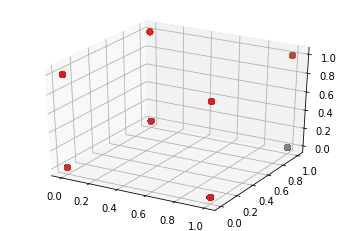

In [192]:
print(X_embedded.shape)
#plt.plot(X_embedded)
# Plot the projected points and show the evaluation score
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1],X_embedded[:, 3], c=ybehaviour, s=30, cmap='Set1')


In [183]:
print(X_embedded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 1. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
